In [2]:
import pandas as pd
import helper
import evaluator
import optuna
from optuna.samplers import TPESampler
import strategy

In [3]:
df = pd.read_csv("in_sample.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index("datetime", inplace=True)
df

,tickersymbol,price,quantity,SMA50,SMA20,STD20,UpperBB,LowerBB,Resistance,Support,AvgVolume20
datetime,,,,,,,,,,,
2021-01-15 10:29:55.249470,VN30F2101,1193.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:30:01.751771,VN30F2101,1194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:30:07.267981,VN30F2101,1193.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:30:18.646696,VN30F2101,1193.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15 10:30:19.898463,VN30F2101,1193.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 14:44:57.512080,VN30F2301,1005.0,NaN,1000.800,1001.090,1.408209,1003.906418,998.273582,1005.0,1000.0,NaN
2022-12-30 14:44:58.368483,VN30F2301,1004.2,NaN,1000.862,1001.300,1.543748,1004.387496,998.212504,1005.0,1000.0,NaN
2022-12-30 14:44:59.390376,VN30F2301,1004.3,NaN,1000.918,1001.505,1.657987,1004.820974,998.189026,1005.0,1000.0,NaN


In [4]:
# Assume df is already loaded and contains required columns like "Close", "SMA50", "UpperBB", "LowerBB", etc.

initial_balance = 10000
contract_size = 16
SMA_WINDOW_LENGTH = 50
TAKE_PROFIT_THRES_MEAN_REVERSION = 5
TAKE_PROFIT_THRES_MOMENTUM = 10
CUT_LOSS_THRES_MEAN_REVERSION = 5
CUT_LOSS_THRES_MOMENTUM = 4

results = strategy.strategy(
    df,
    SMA_WINDOW_LENGTH,
    TAKE_PROFIT_THRES_MEAN_REVERSION,
    TAKE_PROFIT_THRES_MOMENTUM,
    CUT_LOSS_THRES_MEAN_REVERSION,
    CUT_LOSS_THRES_MOMENTUM,
    initial_balance,
    contract_size,
)

# Print results
for key, value in results.items():
    if key != "PnL Over Time":  # Avoid printing a long list
        print(f"{key}: {value}")


Initial Balance: 10000
Final Balance: 44535.999999999985
Win Rate: 97.10144927536231
Total Trades: 138
Winning Trades: 134
Losing Trades: 4
Accumulated Return: 3.453599999999999
Sharpe Ratio: 0.006370605586075102
Max Drawdown: -0.0010037137408411409


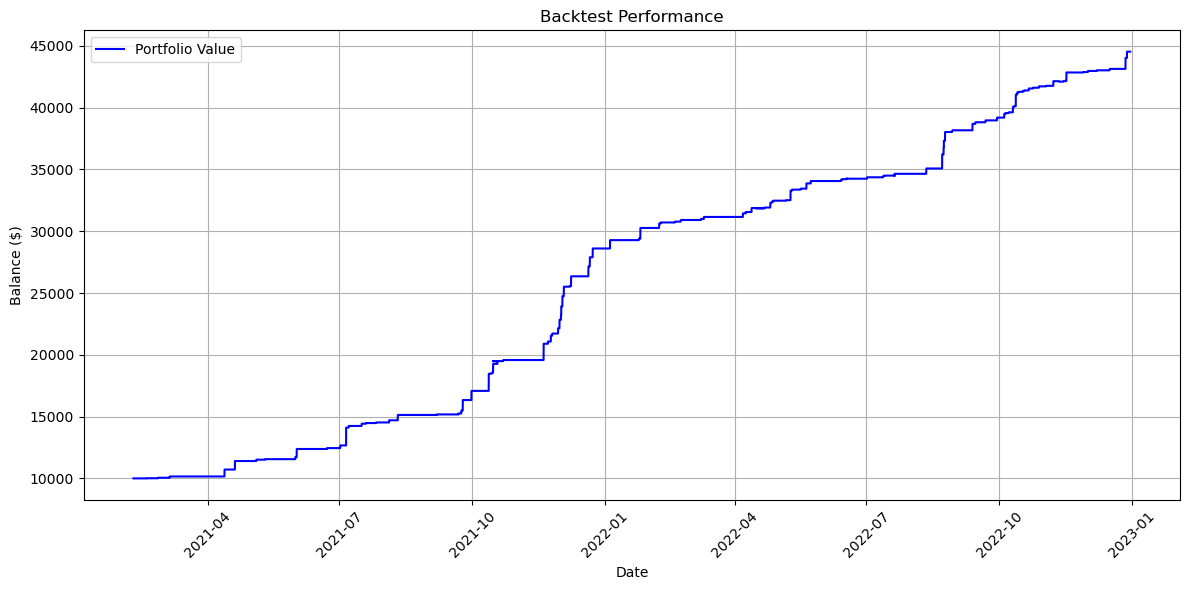

In [5]:
PnL = results["PnL Over Time"]
date_list = df.index[SMA_WINDOW_LENGTH - 1:]  # Align dates with pnl_list length

helper.plot_performance(PnL, date_list)
